## 1) Load the Monet_to_Photo Dataset using Pytorch.

### Importing required libraries

In [1]:
!pip install torch_snippets torch_summary --quiet
import itertools
from PIL import Image
from torch_snippets import *
from torchvision import transforms
from torchvision.utils import make_grid
from torchsummary import summary
from torch.utils.data import DataLoader, SubsetRandomSampler

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyterlab 4.1.2 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
jupyterlab-lsp 5.0.3 requires jupyter-lsp>=2.0.0, but you have jupyter-lsp 1.5.1 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
momepy 0.7.0 requires shapely>=2, but you have shapely 1.8.5.post1 which is incompatible.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


### Looking at what the shape of our training images are

In [2]:
img = Image.open('/kaggle/input/monet2photo/testA/00010.jpg')
img.size

(256, 256)

### Defining image transformations (augmentation)

In [3]:
IMAGE_SIZE = 256
device = 'cuda' if torch.cuda.is_available() else 'cpu'
transform = transforms.Compose([
    transforms.Resize(int(IMAGE_SIZE*1.33)),
    transforms.RandomCrop((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

### Making our Train and Test Dataset

In [4]:
class Monet2PhotoDataset(Dataset):
    def __init__(self, monets, photos):
        ### getting the list of images
        self.monets = Glob(monets)
        self.photos = Glob(photos)

    def __getitem__(self, ix):
        monet = self.monets[ix % len(self.monets)]
        ### Choosing a random photo image to pair with the chosen monet image
        photo = choose(self.photos)
        monet = Image.open(monet).convert('RGB')
        photo = Image.open(photo).convert('RGB')
        return monet, photo

    def __len__(self): return max(len(self.monets), len(self.photos))
    def choose(self): return self[randint(len(self))]

    def collate_fn(self, batch): #batch function
        ### The zip function breaks the tuples into two lists
        srcs, trgs = list(zip(*batch))

        srcs = torch.cat([transform(img)[None] for img in srcs], 0).to(device).float()
        trgs = torch.cat([transform(img)[None] for img in trgs], 0).to(device).float()
        return srcs.to(device), trgs.to(device)

### Initializing the Data Loader

In [5]:
trn_ds = Monet2PhotoDataset('/kaggle/input/monet2photo/trainA', '/kaggle/input/monet2photo/trainB')
val_ds = Monet2PhotoDataset('/kaggle/input/monet2photo/testA', '/kaggle/input/monet2photo/testB')

num_images = 2000
subset_sampler = SubsetRandomSampler(range(num_images))

trn_dl = DataLoader(trn_ds, batch_size=1, collate_fn=trn_ds.collate_fn, sampler=subset_sampler)
val_dl = DataLoader(val_ds, batch_size=5, shuffle=True, collate_fn=val_ds.collate_fn)

print(len(trn_dl))
print(len(val_dl))

2000

151

## 2) Create and train Cycle GAN on this dataset. 

### Defining our CYCLE GAN

In [6]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

### Defining a Residual Block

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3),
            nn.InstanceNorm2d(in_features),
        )

    def forward(self, x):
        return x + self.block(x)

![generator and discriminator](https://www.researchgate.net/publication/343075688/figure/fig3/AS:916527951917056@1595528700573/Architecture-of-the-generator-and-discriminator-of-unpaired-CycleGAN-Conv-2D.ppm)

### Generator Class

In [8]:
class GeneratorResNet(nn.Module):
    def __init__(self, num_residual_blocks=9):
        super(GeneratorResNet, self).__init__()
        out_features = 64
        channels = 3
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(channels, out_features, 7),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features
        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Output layer
        model += [nn.ReflectionPad2d(channels), nn.Conv2d(out_features, channels, 7), nn.Tanh()]
        self.model = nn.Sequential(*model)
        self.apply(weights_init_normal)
    def forward(self, x):
        return self.model(x)

### Discriminator Class

In [9]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        channels, height, width = 3, IMAGE_SIZE, IMAGE_SIZE

        def discriminator_block(in_filters, out_filters, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=2, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(512, 1, 4, padding=1)
        )
        self.apply(weights_init_normal)

    def forward(self, img):
        return self.model(img)

### How do we generate samples from our Cycle GAN

In [10]:
@torch.no_grad()
def generate_sample():
    data = next(iter(val_dl))
    G_AB.eval()
    G_BA.eval()

    real_A, real_B = data
    fake_B = G_AB(real_A)
    fake_A = G_BA(real_B)
    # Arange images along x-axis
    real_A = make_grid(real_A, nrow=5, normalize=True)
    real_B = make_grid(real_B, nrow=5, normalize=True)
    fake_A = make_grid(fake_A, nrow=5, normalize=True)
    fake_B = make_grid(fake_B, nrow=5, normalize=True)
    # Arange images along y-axis
    image_grid = torch.cat((real_A, fake_B, real_B, fake_A), 1)
    show(image_grid.detach().cpu().permute(1,2,0).numpy(), sz=12)

### Defining the Generator Training Step

In [11]:
def generator_train_step(Gs, optimizer, real_A, real_B):
    G_AB, G_BA = Gs
    optimizer.zero_grad()
    loss_id_A = criterion_identity(G_BA(real_A), real_A)
    loss_id_B = criterion_identity(G_AB(real_B), real_B)

    loss_identity = (loss_id_A + loss_id_B) / 2
    fake_B = G_AB(real_A)
    loss_GAN_AB = criterion_GAN(D_B(fake_B), torch.Tensor(np.ones((len(real_A), 1, 16, 16))).to(device))
    fake_A = G_BA(real_B)
    loss_GAN_BA = criterion_GAN(D_A(fake_A), torch.Tensor(np.ones((len(real_A), 1, 16, 16))).to(device))

    loss_GAN = (loss_GAN_AB + loss_GAN_BA) / 2
    recov_A = G_BA(fake_B)
    loss_cycle_A = criterion_cycle(recov_A, real_A)
    recov_B = G_AB(fake_A)
    loss_cycle_B = criterion_cycle(recov_B, real_B)

    loss_cycle = (loss_cycle_A + loss_cycle_B) / 2
    loss_G = loss_GAN + lambda_cyc * loss_cycle + lambda_id * loss_identity
    loss_G.backward()
    optimizer.step()
    return loss_G, loss_identity, loss_GAN, loss_cycle, loss_G, fake_A, fake_B

### Defining the Discriminator Training Step

In [12]:
def discriminator_train_step(D, real_data, fake_data, optimizer):
    optimizer.zero_grad()
    loss_real = criterion_GAN(D(real_data), torch.Tensor(np.ones((len(real_data), 1, 16, 16))).to(device))
    loss_fake = criterion_GAN(D(fake_data.detach()), torch.Tensor(np.zeros((len(real_data), 1, 16, 16))).to(device))
    loss_D = (loss_real + loss_fake) / 2
    loss_D.backward()
    optimizer.step()
    return loss_D

In [13]:
G_AB = GeneratorResNet().to(device)
G_BA = GeneratorResNet().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

optimizer_G = torch.optim.Adam(
    itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=0.0002, betas=(0.5, 0.999)
)
optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=0.0002, betas=(0.5, 0.999))

lambda_cyc, lambda_id = 10.0, 5.0

## 3) Show your results( Few converted images).

### Training the CYCLE GAN. Increase the number of epochs for better results

In [ ]:
n_epochs = 10
log = Report(n_epochs)
for epoch in range(n_epochs):
    N = len(trn_dl)
    for bx, batch in enumerate(trn_dl):
        real_A, real_B = batch

        loss_G, loss_identity, loss_GAN, loss_cycle, loss_G, fake_A, fake_B = generator_train_step((G_AB,G_BA), optimizer_G, real_A, real_B)
        loss_D_A = discriminator_train_step(D_A, real_A, fake_A, optimizer_D_A)
        loss_D_B = discriminator_train_step(D_B, real_B, fake_B, optimizer_D_B)
        loss_D = (loss_D_A + loss_D_B) / 2

        log.record(epoch+(1+bx)/N, loss_D=loss_D.item(), loss_G=loss_G.item(),
                   loss_GAN=loss_GAN.item(), loss_cycle=loss_cycle.item(),
                   loss_identity=loss_identity.item(), end='\r')
    generate_sample()

    log.report_avgs(epoch+1)

100%|██████████| 111/111 [00:02<00:00, 37.86it/s]


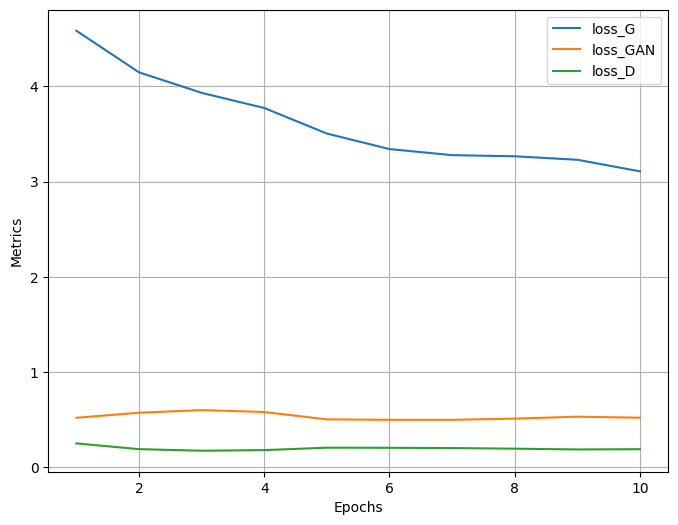

In [15]:
log.plot_epochs(['loss_G','loss_GAN', 'loss_D'])

## 4) load your favorite image (or your picture) apply Cyclegan and upload it with the report. 

In [16]:
class SinglePhotoDataset(Dataset):
    def __init__(self, photos, transform=None):
        ### getting the list of images
        self.photos = Glob(photos)
        self.transform = transform

    def __getitem__(self, ix):
        photo = choose(self.photos)
        photo = Image.open(photo).convert('RGB')
        return photo

    def __len__(self): return len(self.photos)
    def choose(self): return self[randint(len(self))]

    def collate_fn(self, batch): #batch function
        srcs = list(batch)
        srcs = torch.cat([self.transform(img)[None] for img in srcs], 0).float()
        return srcs

In [17]:
fav_ds = SinglePhotoDataset('/kaggle/input/fav-img', transform=transform)
fav_dl = DataLoader(fav_ds, batch_size=1, collate_fn=fav_ds.collate_fn)

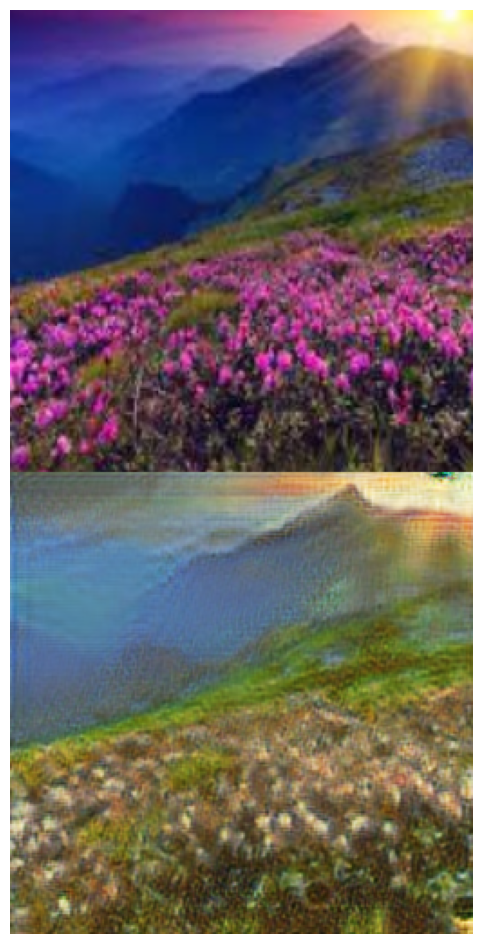

In [18]:
data = next(iter(fav_dl))
G_AB.eval()
G_BA.eval()

real_A = data.to(device)
fake_B = G_AB(real_A)
fake_A = G_BA(fake_B)

# Move fake_B and fake_A to the same device as real_A
fake_B = fake_B.to(device)
fake_A = fake_A.to(device)

# Arange images along x-axis
real_A = make_grid(real_A, nrow=1, normalize=True)
fake_A = make_grid(fake_A, nrow=1, normalize=True)
fake_B = make_grid(fake_B, nrow=1, normalize=True)
# Arange images along y-axis
image_grid = torch.cat((real_A, fake_A), 1)
show(image_grid.detach().cpu().permute(1,2,0).numpy(), sz=12)

### Report - The 1st image is one of my favourite images taken from Google Images which depicts a scenery and I applied CycleGan on it which gave me the output as above.

**Note: Due to extensive training time and computational constraints I have completed the assignment with 2000 images and 10 epochs.** Google Colab and Kaggle notebooks were disconnecting for entire dataset.

## https://github.com/daminivichare66/Deep_Learning_CycleGANs